# MNEflow basic calssification example

# 1. Importing data

### 1.1.from MNE epochs

If you use MNE-python, all you need is to provide your epochs file (or list of epoch files) to mneflow.produce_tfrecords


In [7]:
%pylab inline
#get epochs using your mne-python pipeline
import os
import tensorflow as tf
from time import time
import mne
from mne.datasets import multimodal
os.chdir('/m/nbe/project/rtmeg/problearn/mneflow/')
import mneflow

mne.set_log_level(verbose='CRITICAL')

fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
#get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]

epochs_list = [mne.Epochs(raw, **c) for c in cond]

#here we concatenate epochs because each input file contains just one condition
#otherwise mneflow.produce_tfrecords can handle a list of epochs objects
epochs = mne.concatenate_epochs(epochs_list)
#pick only planar gradiometers
epochs = epochs.pick_types(meg='grad')
#print(epochs.info)

Populating the interactive namespace from numpy and matplotlib


/u/62/zubarei1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cond', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Convert epochs to TFRecord format

In [2]:
#Specify import options

import_opt = dict(savepath='../tfr/', #path where TFR files will be saved
                   out_name='mne_sample_epochs1', #name of TFRecords files
                   fs=600,
                   input_type='trials',
                   target_type='int',
                   picks = {'meg':'grad'},
                   scale=True, #apply baseline_scaling
                   crop_baseline=True, #remove baseline interval after scaling
                   decimate = 2,
                   scale_interval=(0,60), #indices in time axis corresponding to baseline interval
                   val_size=0.15, #validation set size set to 15% of all data
                   overwrite=True) 


#write TFRecord files and metadata file to disk
#meta = mneflow.produce_tfrecords([epochs],**import_opt)  
meta = mneflow.produce_tfrecords([epochs],**import_opt)  

processing epochs
input shape: (940, 204, 361)
target shape: (940,)
Prepocessed sample shape: (204, 151)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


## Other import options
### 1.2 Saved mne.epochs (*-epo.fif) files
Alternatively, if your epochs are saved to disk provide a str (or list of str) with path(s) to your -epo.fif files

e.g. this will work

```python
epochs.save('test_saved_epochs.fif')
meta = mneflow.produce_tfrecords('test_saved_epochs.fif',**opt)
```
### 1.3. Arrays in *.mat or *.npz format
if the first argument is str mneflow.produce_tfrecords can also accept *.mat or *.npz format

e.g.

```python
data_path = '/m/nbe/scratch/braindata/izbrv/detection_data/'
filenames = [data_path +'sub' + str(i) + '-grad.npz' for i in range(1,4)]
meta = mneflow.produce_tfrecords(filenames,**opt)
```
In this case, specify iput_type='array', and also provide array_keys keyword argument

e.g. 

```python
array_keys={'X':'my_data_samples','y':'my_labels'}
```

### 1.4. Tuple of (data, labels)
Finally, if you have a more complex preprocessing pipeline, you can feed you data and labels as a tuple of arrays

```python
X = epochs.get_data()
y = epochs.events[:,2]
meta = mneflow.produce_tfrecords((X,y),**opt)
```


# 2. Initialize the dataset object using the generated metadata file

The dataset object includes several methods that allow experimenting with the dataset without the need to repeat the preprocessing or overwriting the TFRecord files each time.

For example, you can train the model using any subset of classes, channels or reduce the sampling rate by decimating across the time domain.

In [3]:
dataset = mneflow.Dataset(meta, train_batch = 200, class_subset=None, pick_channels=None, decim=None)

W0113 17:09:55.614364 140280048523008 deprecation_wrapper.py:119] From /m/nbe/project/rtmeg/problearn/mneflow/mneflow/data.py:135: The name tf.parse_single_example is deprecated. Please use tf.io.parse_single_example instead.

W0113 17:09:55.626882 140280048523008 deprecation.py:323] From /m/nbe/project/rtmeg/problearn/mneflow/mneflow/data.py:114: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


# 3. Choose from already implemented models

MNEflow pipeline consists of three major parts:
1. dataset
2. optimizer
3. computational graph

Each part has its own set of hyper-parameters and methods that can be tuned. See help for mneflow.Dataset
and mneflow.Optimizer and mneflow.models.Model for more details.
In this example will we use LF-CNN network


In [4]:
#specify optimizer parmeters
optimizer_params = dict(l1_lambda=3e-4,learn_rate=3e-4)

optimizer = mneflow.Optimizer(**optimizer_params)

In [8]:
#specify parameters specific to LF-CNN
lf_params = dict(n_ls=64, #number of latent factors
              filter_length=17, #convolutional filter length in time samples
              pooling = 5, #pooling factor
              stride = 5, #stride parameter for pooling layer
              padding = 'SAME',
              dropout = .5,
              nonlin = tf.nn.relu,
              pool_type = 'max',  
              model_path = import_opt['savepath']) #path for storing the saved model

#initialize the model using the dataset and optimizer objects, and the hyper-parameter dictionary
model = mneflow.models.LFCNN(dataset, optimizer, lf_params)

#this will initialize the iterators over the dataset,the computational graph and the optimizer
model.build()

W0113 17:11:26.813615 140280048523008 deprecation_wrapper.py:119] From /m/nbe/project/rtmeg/problearn/mneflow/mneflow/layers.py:281: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0113 17:11:26.854630 140280048523008 deprecation.py:506] From /m/nbe/project/rtmeg/problearn/mneflow/mneflow/layers.py:63: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0113 17:11:26.865126 140280048523008 deprecation_wrapper.py:119] From /m/nbe/project/rtmeg/problearn/mneflow/mneflow/models.py:96: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0113 17:11:26.874578 140280048523008 deprecation_wrapper.py:119] From /m/nbe/project/rtmeg/problearn/mneflow/mneflow/optimize.py:106: The name tf.losses.softmax_cross_entropy is deprecated. Please use tf.com

X0: (?, 204, 151)
de-mix init : OK
dmx (?, 151, 1, 64)
lf-inp (?, 151, 1, 64)
conv init : OK
lf-inp (?, 151, 1, 64)
f: (17, 1, 64, 1)
lf-out (?, 31, 1, 64)
fc ::: 1984 8
fc init : OK
X: (?, 204, 151, 1)
y_pred: (?, 8)
L1 penalty applied to weights
Initialization complete!


In [10]:
#train the model
start = time()
model.train(n_iter=3000,eval_step=250,min_delta=1e-6,early_stopping=1)
stop = time() - start
print('Trained in {:.2f}s'.format(stop))

i 0, tr_loss 0.43427, tr_acc 1 v_loss 0.881121, v_acc 0.87234
i 250, tr_loss 0.384862, tr_acc 1 v_loss 0.859818, v_acc 0.882979
* Patience count 1
early stopping...
stopped at: epoch 500, val loss 0.859818, val acc 0.882979
Trained in 21.18s


# 4. Explore the trained model parameters
LFCNN allows to interpret the trained parameters in terms of toporaphies and the spectral properties of the latent sources contributing to each class. 

out_w: (1984, 8)
demx: (204, 64) kern: (17, 64) tc_out: (846, 31, 64) out_w: (31, 64, 8)
Maximum spearman r * weight: 0.05044806463591013
Maximum spearman r * weight: 0.09373593858254406
Maximum spearman r * weight: 0.0706230674438087
Maximum spearman r * weight: 0.06757495816408474
Maximum spearman r * weight: 0.07430629810018095
Maximum spearman r * weight: 0.07530423737683568
Maximum spearman r * weight: 0.05565088720975591
Maximum spearman r * weight: 0.07089645222566618


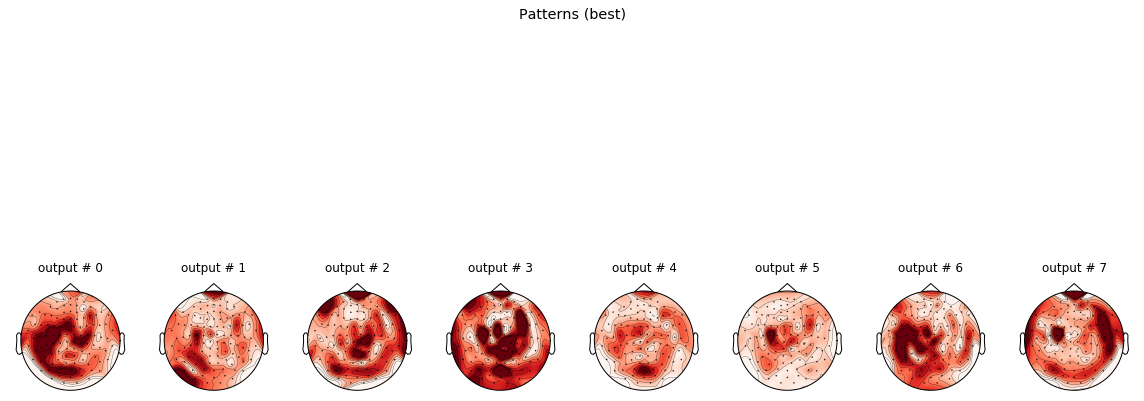

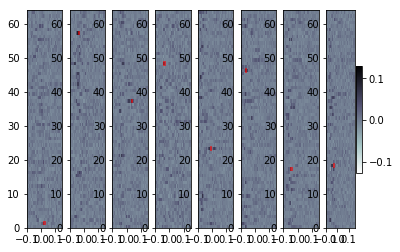

In [20]:

model.compute_patterns(data_path=meta['train_paths'], output='patterns')
f = model.plot_patterns(sensor_layout='Vectorview-grad', sorting='best', scale=False)


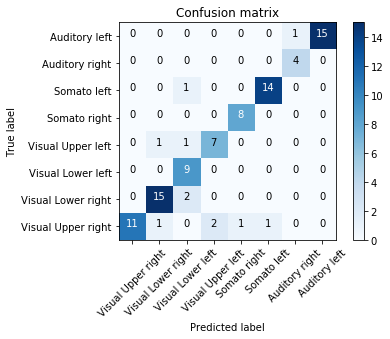

In [15]:
#Plotting the confusion matrix allows to identify analyze whether cetrain classes 
#are systematically harder to classify 
f2 = model.plot_cm(dataset='validation', class_names=condition_names)

Maximum spearman r * weight: 0.0673968021270606
Maximum spearman r * weight: 0.10505114155151477
Maximum spearman r * weight: 0.05777015619617083
Maximum spearman r * weight: 0.04824301176646005
Maximum spearman r * weight: 0.06040520628530867
Maximum spearman r * weight: 0.08297512469391109
Maximum spearman r * weight: 0.023834852737492408
Maximum spearman r * weight: 0.09265705469097109


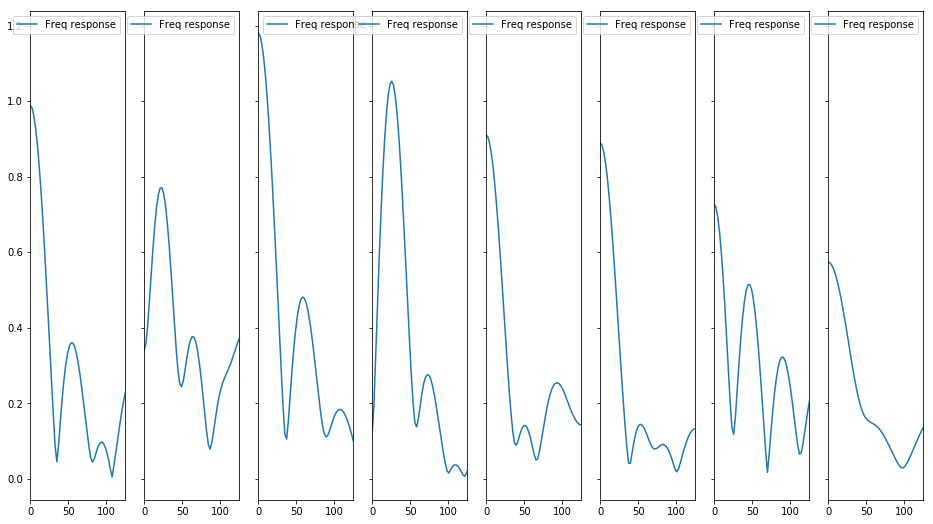

In [18]:
f3 = model.plot_spectra(sorting='best')